In [1]:
import re
import nltk
import time
import numpy as np
import pandas as pd
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import gensim.parsing.preprocessing as gpp
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import gensim
# print(gensim.parsing.preprocessing.STOPWORDS)

### Custom function for data cleaning

In [2]:
def data_cleaning(tweets_struct):
    # Removing links and ampersand attached text from the tweets
    text_list = [re.sub(r"(?:\@|\&|http)\S+", "", item) for item in tweets_struct["Text"]]

    text_list = [gpp.strip_numeric(item) for item in text_list]
    text_list = [gpp.strip_non_alphanum(item) for item in text_list]
    text_list = [gpp.strip_punctuation(item) for item in text_list]
    text_list = [gpp.strip_short(item, minsize=2) for item in text_list]
    text_list = [item.lower() for item in text_list]
    text_list = [gpp.remove_stopwords(item) for item in text_list]

    # Remove everything except text and numbers
    # text_list["text"] = [re.sub(r"[^a-zA-Z0-9]+", ' ', item) for item in text_list["text"]]
    
    return text_list

In [3]:
def frequency_of_words(tweets_df):
    c = tweets_tokenized.apply(pd.value_counts).sum(axis=1, skipna=True).sort_values(ascending=False)
    words = tweets_tokenized.apply(pd.value_counts).sum(axis=1, skipna=True).sum()
    c = c[:10,]
    
    plt.figure(figsize=(10,5))
    plt.title('Frequency of words in tweets')
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    ax = sns.barplot(c.index, c.values, alpha=0.8)
    
    for p in ax.patches:
        ax.annotate("{:.2f}%".format((p.get_height()/words)*100),
                    (p.get_x()+p.get_width()/2.,p.get_height()),
                     ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                     textcoords='offset points')

In [4]:
# Function to count total token words in a DataFrame or a column
def count_words(var):
    if isinstance(var, pd.Series):
        tokens = 0
        for items in var.iteritems():
            tokens += len(items[1].split())
        return tokens
    elif isinstance(var, pd.DataFrame):
        return var.count().sum()
    
# Map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Custom functionfor text lemmatization and removing non-dictionary words
def lemmatize_custom(my_list, c_words):
    start = time.time()
    lemma = nltk.wordnet.WordNetLemmatizer()
    # words = set(nltk.corpus.words.words())

    # c_words = [lemma.lemmatize(x, get_wordnet_pos(x)) for x in c_words]
    # for i in c_words:
    #    words.add(i)
        
    tweets_ll = []
    for item in my_list:
        word_list = item.split()
        word_list = [x for x in word_list if x in c_words]
        word_list = [lemma.lemmatize(x, get_wordnet_pos(x)) for x in word_list]
        # word_list = [x for x in word_list if x in words]
        tweets_ll.append(word_list)
        word_list = None
    end = time.time()
    print("Total time taken in lemmatization: {:.2f} seconds".format(end-start))
    return pd.DataFrame(tweets_ll)

## Preprocessing for Part 2

In [5]:
tweets = pd.read_csv("tweets_behaviour.csv", index_col=0)
words_earlier = count_words(tweets["Text"])
print("Number of rows: {}".format(tweets.shape[0]))
tweets.head()

Number of rows: 33741


,Text,Date,Retweets,Favorites,Mentions,HashTags
0,"Since the moderated lockdown, I haven’t been l...",2020-04-01 00:02:05+00:00,0,0,NaN,NaN
1,so it's online and I thought I could look up t...,2020-04-01 00:03:09+00:00,0,1,NaN,NaN
2,what have i been doing during this time? cooki...,2020-04-01 00:06:12+00:00,0,0,NaN,NaN
3,"To make this stop, we need a complete lockdown...",2020-04-01 00:17:50+00:00,0,1,NaN,NaN
4,I’ve been listening to my music on shuffle sin...,2020-04-01 00:23:46+00:00,0,1,NaN,NaN


In [6]:
tweets_text = data_cleaning(tweets)
pd.DataFrame(tweets_text, columns=["Text"]).head()

,Text
0,moderated lockdown haven listening music sure odd
1,online thought look answers ll watching webcam...
2,time cooking listening lots music facetiming y...
3,stop need complete lockdown happen people time...
4,ve listening music shuffle start lockdown gbs ...


In [7]:
# custom_words are compulsory words not to be removed in lemmatization
custom_words = []

with open("behaviour_words.txt","r") as f:
    lines = [line.strip() for line in f]
for i in lines:
    custom_words.append(i)

print(custom_words[:10])
print("\nRunning lemmatization ...\n")
tweets_tokenized = lemmatize_custom(tweets_text, custom_words)
print("Number of rows: {}".format(tweets_tokenized.shape[0]))
tweets_tokenized.head(5)

['android', 'jabong', 'youtube', 'netflix', 'online', 'played', 'movie', 'watched', 'prime', 'food']

Running lemmatization ...

Total time taken in lemmatization: 50.67 seconds
Number of rows: 33741


,0,1,2,3,4,5,6,7,8,9,10
0,listen,music,None,None,None,None,None,None,None,None,None
1,online,watch,None,None,None,None,None,None,None,None,None
2,listen,music,play,None,None,None,None,None,None,None,None
3,shopping,amazon,None,None,None,None,None,None,None,None,None
4,listen,music,music,None,None,None,None,None,None,None,None


In [8]:
words_after = count_words(tweets_tokenized)
print("Words before preprocessing: {}".format(words_earlier))
print("Words after preprocessing: {}".format(words_after))
print("Words removed: {}".format(words_earlier-words_after))

# Removing duplicate word from rows
df1 = tweets_tokenized.stack().reset_index().drop(columns='level_1').drop_duplicates()
df1['col'] = df1.groupby('level_0').cumcount()
tweets_tokenized = (df1.pivot(index='level_0', columns='col', values=0)
          .rename_axis(index=None, columns=None))

tweets_tokenized.dropna(axis = 0,how = 'all',inplace = True, thresh=2)

print("Number of rows: {}".format(tweets_tokenized.shape[0]))
tweets_tokenized.head(5)

Words before preprocessing: 1102048
Words after preprocessing: 63404
Words removed: 1038644
Number of rows: 21814


,0,1,2,3,4,5,6,7
0,listen,music,NaN,NaN,NaN,NaN,NaN,NaN
1,online,watch,NaN,NaN,NaN,NaN,NaN,NaN
2,listen,music,play,NaN,NaN,NaN,NaN,NaN
3,shopping,amazon,NaN,NaN,NaN,NaN,NaN,NaN
4,listen,music,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Remove multiple products/services from single rows
products = ["amazon","prime"]
new_list = []

for item in tweets_tokenized.itertuples(index=False):
    mult = 0
    for i in list(item):
        if i in products:
            mult += 1

    if mult <= 1:
        new_list.append(list(item))
    else:
        new_list.append([x for x in list(item) if x != "amazon"])

tweets_tokenized = pd.DataFrame(new_list)
tweets_tokenized.index += 1
tweets_tokenized.to_csv("tweets_tokenized_behaviour.csv",header=False,index=False)
tweets_tokenized.head()

,0,1,2,3,4,5,6,7
1,listen,music,NaN,NaN,NaN,NaN,NaN,NaN
2,online,watch,NaN,NaN,NaN,NaN,NaN,NaN
3,listen,music,play,NaN,NaN,NaN,NaN,NaN
4,shopping,amazon,NaN,NaN,NaN,NaN,NaN,NaN
5,listen,music,NaN,NaN,NaN,NaN,NaN,NaN


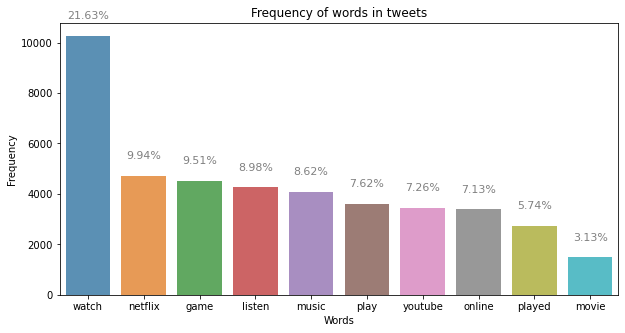

In [10]:
frequency_of_words(tweets_tokenized)

In [11]:
# Convert dataframe to list 
tweets_list = tweets_tokenized.T.apply(lambda x: x.dropna().tolist()).tolist()

# One Hot Encoding
te = TransactionEncoder()
te_ary = te.fit(tweets_list).transform(tweets_list)
tweets_ohe = pd.DataFrame(te_ary, columns = te.columns_)
tweets_ohe.head(5)

,amazon,android,flipkart,food,gaana,game,hotstar,listen,movie,music,...,playstation,prime,saavn,shopping,spotify,swiggy,watch,xbox,youtube,zomato
0,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [12]:
freq_items = apriori(tweets_ohe, min_support=0.01, use_colnames=True, verbose=0)
freq_items.sort_values(by = "support", ascending = False)

,support,itemsets
14,0.470432,(watch)
6,0.216146,(netflix)
2,0.206931,(game)
28,0.195838,"(netflix, watch)"
3,0.195287,(listen)
5,0.187494,(music)
21,0.172596,"(music, listen)"
9,0.165811,(play)
16,0.158018,(youtube)
7,0.155130,(online)


In [13]:
rules = association_rules(freq_items, metric="lift", min_threshold=1)
rules.sort_values(by = ["lift","confidence","support"], ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(amazon),(shopping),0.027414,0.059595,0.020583,0.750836,12.599030,0.018949,3.774244
0,(shopping),(amazon),0.059595,0.027414,0.020583,0.345385,12.599030,0.018949,1.485737
9,(spotify),(listen),0.022417,0.195287,0.021546,0.961145,4.921695,0.017168,20.710760
8,(listen),(spotify),0.195287,0.022417,0.021546,0.110329,4.921695,0.017168,1.098814
16,(shopping),(online),0.059595,0.155130,0.043871,0.736154,4.745408,0.034626,3.202132
17,(online),(shopping),0.155130,0.059595,0.043871,0.282801,4.745408,0.034626,1.311220
6,(music),(listen),0.187494,0.195287,0.172596,0.920538,4.713759,0.135980,10.126998
7,(listen),(music),0.195287,0.187494,0.172596,0.883803,4.713759,0.135980,6.992474
19,(xbox),(play),0.020171,0.165811,0.014990,0.743182,4.482103,0.011646,3.248170
18,(play),(xbox),0.165811,0.020171,0.014990,0.090406,4.482103,0.011646,1.077217
